# Projeto em Análise de Dados

### Importando as bibliotecas necessárias para o projeto

In [246]:
import os
import os.path
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

### 1) Tratamento de Dados - ETL e Criação de Camadas para Backup

#### A parte "E" (extract) do ETL já foi feita de antemão, uma vez que os dados do drive com as planilhas mockadas foram baixados e transferidos para este diretório. Os próximos passos são: Fazer a leitura dos dados e transformação dos mesmos, para posteriormente fazermos o LOAD em um DataFrame do Pandas.

In [247]:
## Inicializo o DataFrame em Pandas:

df = pd.DataFrame()
dfs = [] # Vetor fora do Pandas para receber appends


caminho = 'Tabelas/'
lista_arquivos = os.listdir(caminho)

# 'For' para varrer toda a pasta de planilhas mockadas:
for arquivo in lista_arquivos:
    df_aux = pd.read_csv(caminho+str(arquivo))
    dfs.append(df_aux)

df = pd.concat(dfs, ignore_index=True) # Concatenação de dataframes

df.to_csv('backup/camada_bronze.csv') # transformar Arquivo em .csv para camada Bronze (conceito de Data Engeneering) - Para usar de Backup

df

,ano,uf,genero,mes,numero
0,2019,Rondônia,Masculino,Janeiro,0
1,2019,Rondônia,Masculino,Fevereiro,4
2,2019,Rondônia,Masculino,Março,1
3,2019,Rondônia,Masculino,Abril,0
4,2019,Rondônia,Masculino,Maio,0
...,...,...,...,...,...
4531,2021,Distrito Federal,Feminino,Agosto,12
4532,2021,Distrito Federal,Feminino,Setembro,13
4533,2021,Distrito Federal,Feminino,Outubro,15
4534,2021,Distrito Federal,Feminino,Novembro,20


#### Agora que temos um DataFrame único, podemos fazer o tratamento de dados, pois alguns campos (colunas) ainda estão com o type de 'object'

In [248]:
df.dtypes

ano        int64
uf        object
genero    object
mes       object
numero     int64
dtype: object

#### Não é pertinente deixar duas colunas de data (como por exemplo, ano e mês) separadas, sendo assim podemos juntá-las em uma única e transformar os dados em Date Time

In [249]:
#Criação de um dicionário para mapear os meses e transformá-los em números.

dicionario_mes = {
    'Janeiro': '01',
    'Fevereiro': '02',
    'Março': '03',
    'Abril': '04',
    'Maio': '05',
    'Junho': '06',
    'Julho': '07',
    'Agosto': '08',
    'Setembro': '09',
    'Outubro': '10',
    'Novembro': '11',
    'Dezembro': '12'
}

In [250]:
#Criação da coluna de numero_mes que corresponde ao número do respectvo mês do dicionário acima.
#Utilizei o método map que maepeia os valores do dicionário
df['numero_mes'] = df['mes'].map(dicionario_mes)
df

,ano,uf,genero,mes,numero,numero_mes
0,2019,Rondônia,Masculino,Janeiro,0,01
1,2019,Rondônia,Masculino,Fevereiro,4,02
2,2019,Rondônia,Masculino,Março,1,03
3,2019,Rondônia,Masculino,Abril,0,04
4,2019,Rondônia,Masculino,Maio,0,05
...,...,...,...,...,...,...
4531,2021,Distrito Federal,Feminino,Agosto,12,08
4532,2021,Distrito Federal,Feminino,Setembro,13,09
4533,2021,Distrito Federal,Feminino,Outubro,15,10
4534,2021,Distrito Federal,Feminino,Novembro,20,11


In [251]:
df.dtypes

ano            int64
uf            object
genero        object
mes           object
numero         int64
numero_mes    object
dtype: object

In [252]:
df['ano'] = df['ano'].astype(str) # Transformar o Ano em string, pois ainda está em int
df['numero_mes'] = df['numero_mes'].astype(str) # Transformar o Ano em string, pois ainda está em object
df['data'] = pd.to_datetime(df['ano'] + '-' + df['numero_mes'] + '-01') # Como o dia do mês não importa na análise, podemos omitir esse campo
# Por default, as datas ficarão no formato aaaa-mm-dd, o campo de dia '-dd' ficará sempre '01'

In [253]:
# Verificar se há valores nulos no DataFrame e 'Dropá-los', pois se há algum valor nulo, não devemos considerá-los na análise:
df = df.dropna()
df


,ano,uf,genero,mes,numero,numero_mes,data
0,2019,Rondônia,Masculino,Janeiro,0,01,2019-01-01
1,2019,Rondônia,Masculino,Fevereiro,4,02,2019-02-01
2,2019,Rondônia,Masculino,Março,1,03,2019-03-01
3,2019,Rondônia,Masculino,Abril,0,04,2019-04-01
4,2019,Rondônia,Masculino,Maio,0,05,2019-05-01
...,...,...,...,...,...,...,...
4531,2021,Distrito Federal,Feminino,Agosto,12,08,2021-08-01
4532,2021,Distrito Federal,Feminino,Setembro,13,09,2021-09-01
4533,2021,Distrito Federal,Feminino,Outubro,15,10,2021-10-01
4534,2021,Distrito Federal,Feminino,Novembro,20,11,2021-11-01


In [254]:
# Foi verificado acima que não há valores nulos nas linhas, pois o DataFrame continua com a mesma quantidade de linhas que anteriormente
# Portanto podemos seguir pra a etapa Silver de tratamento de Dados. 
df.to_csv('backup/camada_silver.csv') # transformar Arquivo em .csv para camada Silver (conceito de Data Engeneering) - Para usar de Backup - Dados mais tratados em Silver (tipagem correta).

#### Agora podemos 'Dropar' as colunas 'numero_mes', 'mes' e 'ano' para fins de performance, mas podemos manter as mesmas colunas caso sejam pertinentes na análise (neste caso irei manter as colunas 'mes' e 'ano'). Manterei desta forma, pois os dados já estão 'Safrados' (conceito em DE de agrupamento de data, por exemplo).

#### Neste caso irei dropar apenas a coluna de 'numero_mes', pois a coluna de data já possui toda a informção pertinente.

In [255]:
#Neste passo farei a parte de estabelecer relações entre Estados e suas respectivas regiões, isso para a camada Gold.
df = df.drop(columns='numero_mes') #Tirar a coluna de numero_mes

#Segue o dicionário que relacona os Estados com suas respectivas Regiões do BR:
uf_regioes = {
    'Acre': 'Norte',
    'Alagoas': 'Nordeste',
    'Amapá': 'Norte',
    'Amazonas': 'Norte',
    'Bahia': 'Nordeste',
    'Ceará': 'Nordeste',
    'Distrito Federal': 'Centro-Oeste',
    'Espírito Santo': 'Sudeste',
    'Goiás': 'Centro-Oeste',
    'Maranhão': 'Nordeste',
    'Mato Grosso': 'Centro-Oeste',
    'Mato Grosso do Sul': 'Centro-Oeste',
    'Minas Gerais': 'Sudeste',
    'Pará': 'Norte',
    'Paraíba': 'Nordeste',
    'Paraná': 'Sul',
    'Pernambuco': 'Nordeste',
    'Piauí': 'Nordeste',
    'Rio de Janeiro': 'Sudeste',
    'Rio Grande do Norte': 'Nordeste',
    'Rio Grande do Sul': 'Sul',
    'Rondônia': 'Norte',
    'Roraima': 'Norte',
    'Santa Catarina': 'Sul',
    'São Paulo': 'Sudeste',
    'Sergipe': 'Nordeste',
    'Tocantins': 'Norte'
}

df['regiao'] = df['uf'].map(uf_regioes) #Mapear as regiões dentro do DataFrame

df.to_csv('backup/camada_gold.csv') #Criação da Camada Gold (última camada e configuração ideal para a análise de dados)
df

,ano,uf,genero,mes,numero,data,regiao
0,2019,Rondônia,Masculino,Janeiro,0,2019-01-01,Norte
1,2019,Rondônia,Masculino,Fevereiro,4,2019-02-01,Norte
2,2019,Rondônia,Masculino,Março,1,2019-03-01,Norte
3,2019,Rondônia,Masculino,Abril,0,2019-04-01,Norte
4,2019,Rondônia,Masculino,Maio,0,2019-05-01,Norte
...,...,...,...,...,...,...,...
4531,2021,Distrito Federal,Feminino,Agosto,12,2021-08-01,Centro-Oeste
4532,2021,Distrito Federal,Feminino,Setembro,13,2021-09-01,Centro-Oeste
4533,2021,Distrito Federal,Feminino,Outubro,15,2021-10-01,Centro-Oeste
4534,2021,Distrito Federal,Feminino,Novembro,20,2021-11-01,Centro-Oeste


In [256]:
df.dtypes

ano               object
uf                object
genero            object
mes               object
numero             int64
data      datetime64[ns]
regiao            object
dtype: object

#### Sendo assim, o Tratamento de Dados está concluído!

#### ETL - Feito!

#### Criação de Camadas para Backup (Bronze, Silver e Gold) - Feito!

### 2) Análise dos Dados tratados

#### Primeiramente é ideal plotarmos os gráficos de Data x Número (Série Temporal) para verificar se há alguma correlação entre ocorrências no número ao longo do tempo, para isto faremos uma primeira regressão linear e verificar o R², se houver um R² relativamente alto, devemos nos prender aos eventos que acontecem ao longo do tempo, caso contrário, seguimos com a análise em algumas outras direções.

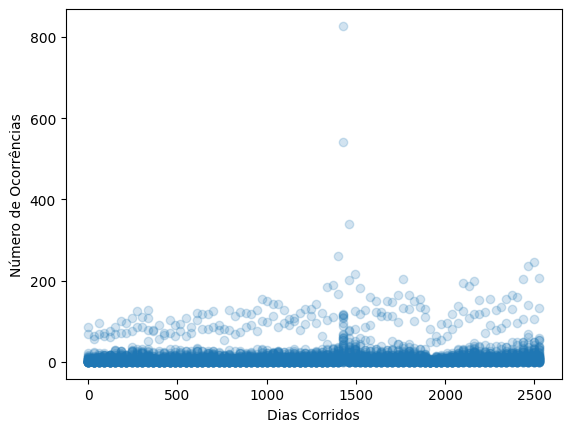

In [257]:
df['data_num'] = (df['data'] - df['data'].min()).dt.days # Variação de dias corridos para ter um "x" de mais fácl entendimento e visbilidade
plt.scatter(df['data_num'], df['numero'], alpha=0.2)
plt.xlabel('Dias Corridos')
plt.ylabel('Número de Ocorrências')
plt.show()

In [258]:
#Regressão Linear e seu respectivo R²:

x = df['data_num']
y = df['numero']
X = sm.add_constant(x)

#Criação do modelo
modelo = sm.OLS(y, X).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                 numero   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     24.65
Date:                Mon, 20 May 2024   Prob (F-statistic):           7.14e-07
Time:                        08:20:42   Log-Likelihood:                -21520.
No. Observations:                4536   AIC:                         4.304e+04
Df Residuals:                    4534   BIC:                         4.306e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7507      0.818      9.472      0.0

##### Como o R² deu resultou em um valor muito ínfimo, vamos analisar alguns histogramas e entender a Frequência de ocorrências por Categorias ou 'Groupby' do Pandas.

#### Histogramas:

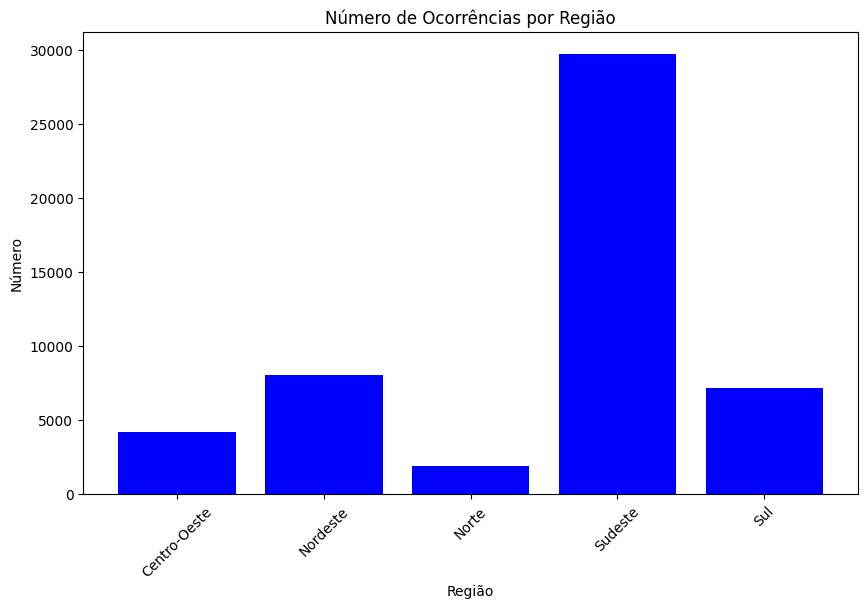

In [259]:
# Agrupar por região, somar os números e resetar o index
df_regiao = df.groupby('regiao')['numero'].sum().reset_index()

# Plot do histograma:
plt.figure(figsize=(10, 6))
plt.bar(df_regiao['regiao'], df_regiao['numero'], color='blue')
plt.xlabel('Região')
plt.ylabel('Número')
plt.title('Número de Ocorrências por Região')
plt.xticks(rotation=45)
plt.show()

In [260]:
df_regiao

,regiao,numero
0,Centro-Oeste,4192
1,Nordeste,8070
2,Norte,1898
3,Sudeste,29714
4,Sul,7192


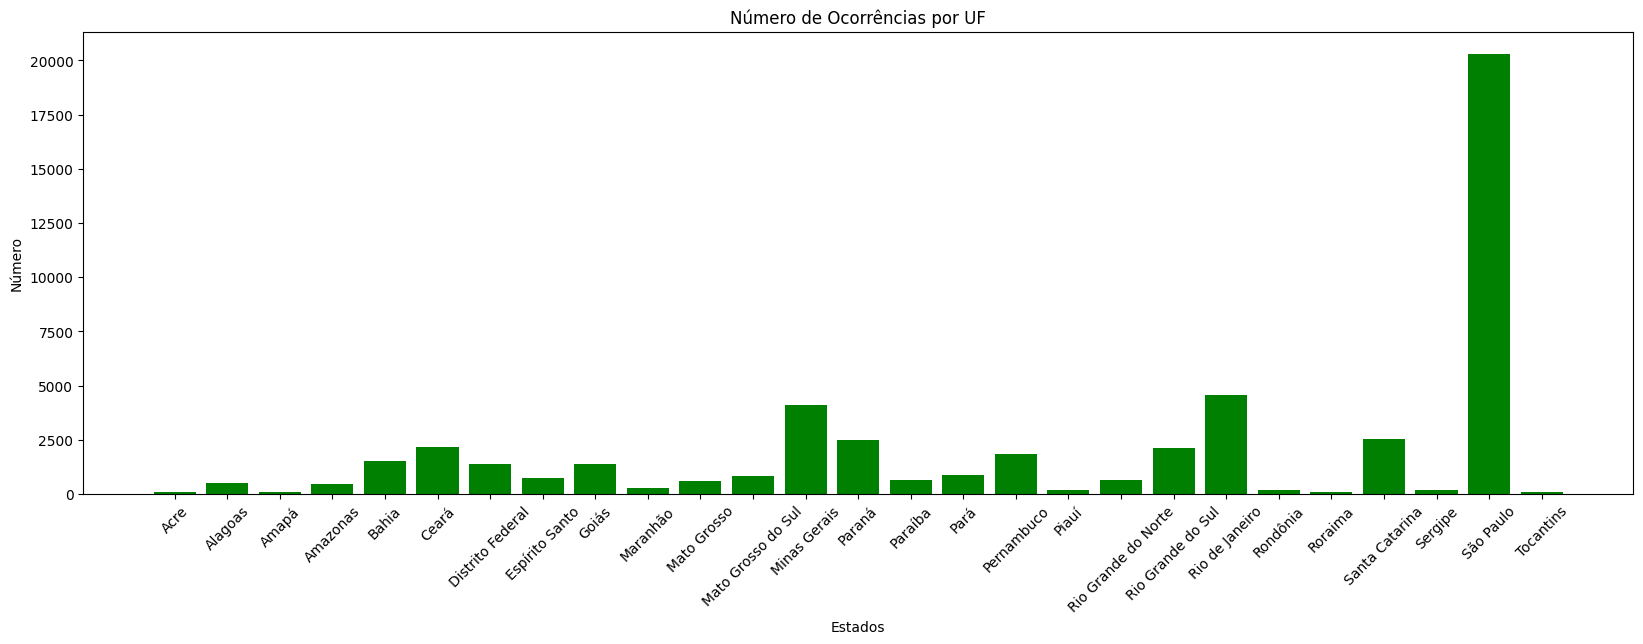

In [261]:
# Agrupar por uf, somar os números e resetar o index
df_uf = df.groupby('uf')['numero'].sum().reset_index()

# Plot do histograma:
plt.figure(figsize=(20, 6)) #Ajuste de 20 x 6 para alongar o gráfico na horizontal
plt.bar(df_uf['uf'], df_uf['numero'], color='green')
plt.xlabel('Estados')
plt.ylabel('Número')
plt.title('Número de Ocorrências por UF')
plt.xticks(rotation=45)
plt.show()

In [262]:
df_uf

,uf,numero
0,Acre,81
1,Alagoas,512
2,Amapá,81
3,Amazonas,454
4,Bahia,1531
5,Ceará,2166
6,Distrito Federal,1378
7,Espírito Santo,758
8,Goiás,1367
9,Maranhão,306


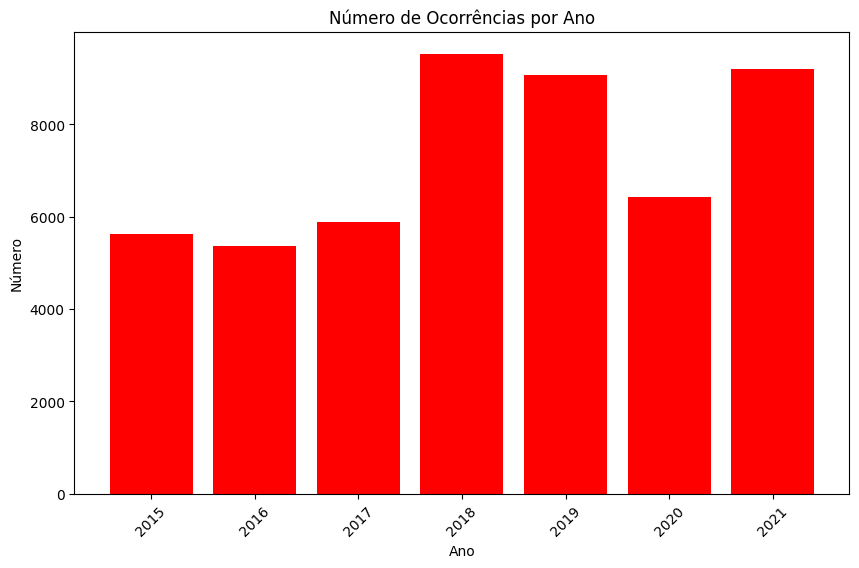

In [263]:
# Agrupar por ano, somar os números e resetar o index
df_ano = df.groupby('ano')['numero'].sum().reset_index()

# Plot do histograma:
plt.figure(figsize=(10, 6))
plt.bar(df_ano['ano'], df_ano['numero'], color='red')
plt.xlabel('Ano')
plt.ylabel('Número')
plt.title('Número de Ocorrências por Ano')
plt.xticks(rotation=45)
plt.show()

In [264]:
df_ano

,ano,numero
0,2015,5614
1,2016,5354
2,2017,5887
3,2018,9520
4,2019,9056
5,2020,6433
6,2021,9202


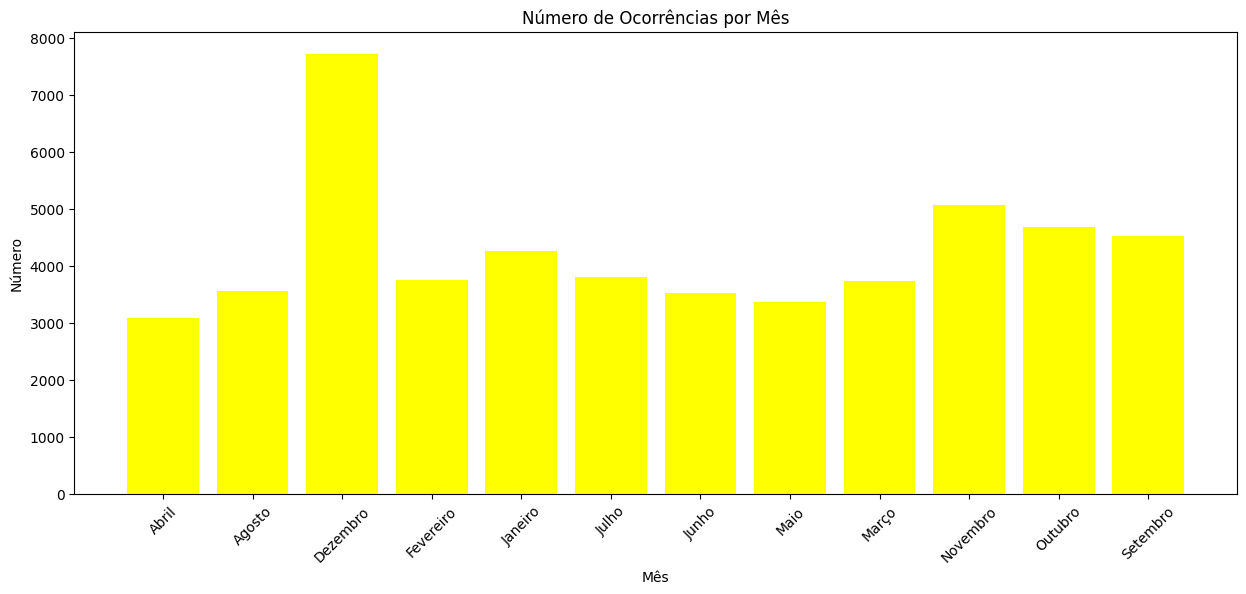

In [265]:
# Agrupar por mês, somar os números e resetar o index
df_mes = df.groupby('mes')['numero'].sum().reset_index()

# Plot do histograma:
plt.figure(figsize=(15, 6))
plt.bar(df_mes['mes'], df_mes['numero'], color='yellow')
plt.xlabel('Mês')
plt.ylabel('Número')
plt.title('Número de Ocorrências por Mês')
plt.xticks(rotation=45)
plt.show()

In [266]:
df_mes

,mes,numero
0,Abril,3077
1,Agosto,3566
2,Dezembro,7716
3,Fevereiro,3753
4,Janeiro,4252
5,Julho,3806
6,Junho,3519
7,Maio,3371
8,Março,3727
9,Novembro,5062


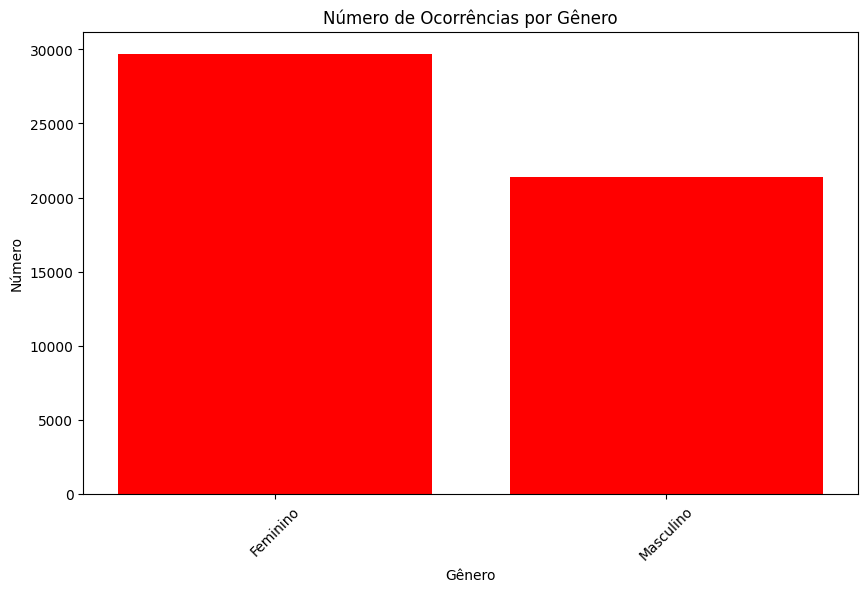

In [290]:
# Agrupar por genero, somar os números e resetar o index
df_gen = df.groupby('genero')['numero'].sum().reset_index()

# Plot do histograma:
plt.figure(figsize=(10, 6))
plt.bar(df_gen['genero'], df_gen['numero'], color='red')
plt.xlabel('Gênero')
plt.ylabel('Número')
plt.title('Número de Ocorrências por Gênero')
plt.xticks(rotation=45)
plt.show()

In [291]:
df_gen

,genero,numero
0,Feminino,29693
1,Masculino,21373


#### Serie Temporal do Sudeste, Região que mais apresenta número de ocorrências e do ano de 2018 (maor número de ocorrências):

In [279]:
#Filtro de Sudeste e ano de 2018 - passar para um novo DataFrame: df_sp
df_sp = df[(df['regiao'] == 'Sudeste') & (df['ano'] == '2018')]

In [280]:
df_sp

,ano,uf,genero,mes,numero,data,regiao,data_num
1488,2018,Minas Gerais,Masculino,Janeiro,11,2018-01-01,Sudeste,1096
1489,2018,Minas Gerais,Masculino,Fevereiro,21,2018-02-01,Sudeste,1127
1490,2018,Minas Gerais,Masculino,Março,26,2018-03-01,Sudeste,1155
1491,2018,Minas Gerais,Masculino,Abril,17,2018-04-01,Sudeste,1186
1492,2018,Minas Gerais,Masculino,Maio,22,2018-05-01,Sudeste,1216
...,...,...,...,...,...,...,...,...
3799,2018,São Paulo,Feminino,Agosto,120,2018-08-01,Sudeste,1308
3800,2018,São Paulo,Feminino,Setembro,184,2018-09-01,Sudeste,1339
3801,2018,São Paulo,Feminino,Outubro,189,2018-10-01,Sudeste,1369
3802,2018,São Paulo,Feminino,Novembro,260,2018-11-01,Sudeste,1400


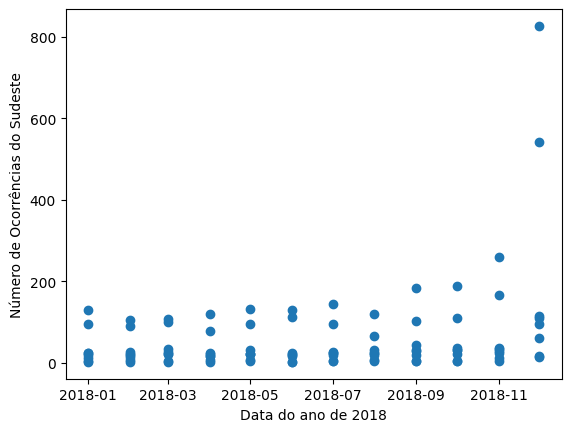

In [281]:
plt.scatter(df_sp['data'], df_sp['numero'])
plt.xlabel(f'Data do ano de 2018')
plt.ylabel(f'Número de Ocorrências do Sudeste')
plt.show()

#### Sendo assim, podemos criar uma função onde a mesma recebe a Região filtrada pelo ano e analisar a Série Temporal naquele cohort (de Região e Ano).

In [284]:
# Aqui a função podia ter uma validação de dados (com erros), com Try e Except dentro de um While, por exemplo.
# Mas vamos assumir que o time saiba os intervalos de tempo válidos e também as regiões válidas!

def funcao_cohort():
    regiao = input('Entre com a Região (Sudeste, Nordeste, Norte, Centro-Oeste ou Sul):').lower().title() # Deixa as letras minúsculas e depois deixa a letra inicial maiúscula (como deve ser no df)
    ano = input('Entre com o Ano (2015 a 2021):')
    df_aux = df[(df['regiao'] == f'{regiao}') & (df['ano'] == f'{ano}')]
    plt.xlabel(f'Data do ano de {ano}')
    plt.ylabel('Número de Ocorrências')
    plt.title(f'Região {regiao}')
    plt.scatter(df_aux['data'], df_aux['numero'])
    plt.show()
    return df_aux

# A função 'funcao_cohort() nos devolve um df_aux (DataFrame auxiliar) e faclita na análise temporal de um dado cohort. A função também retorna o plot da Região e Ano considerado.

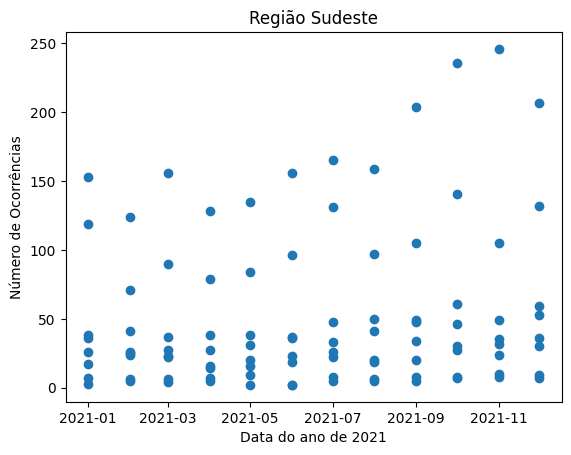

,ano,uf,genero,mes,numero,data,regiao,data_num
2136,2021,Minas Gerais,Masculino,Janeiro,26,2021-01-01,Sudeste,2192
2137,2021,Minas Gerais,Masculino,Fevereiro,24,2021-02-01,Sudeste,2223
2138,2021,Minas Gerais,Masculino,Março,22,2021-03-01,Sudeste,2251
2139,2021,Minas Gerais,Masculino,Abril,14,2021-04-01,Sudeste,2282
2140,2021,Minas Gerais,Masculino,Maio,16,2021-05-01,Sudeste,2312
...,...,...,...,...,...,...,...,...
4447,2021,São Paulo,Feminino,Agosto,159,2021-08-01,Sudeste,2404
4448,2021,São Paulo,Feminino,Setembro,204,2021-09-01,Sudeste,2435
4449,2021,São Paulo,Feminino,Outubro,236,2021-10-01,Sudeste,2465
4450,2021,São Paulo,Feminino,Novembro,246,2021-11-01,Sudeste,2496


In [285]:
funcao_cohort()

##### Se temos um df_aux para cada cohort (Região e Ano), podemos fazer uma série temporal de Qualquer região e ano do DataFrame principal (camada gold), logo podemos seguir com regressões lineares e prever o número de ocorrências em cada região para os próximos anos, isso nos faz ganhar muito tempo na análise!

##### Porém o problema é bem claro, devemos explorar o lado do objetivo do Cliente:

##### *Queremos entender quais insights conseguimos tirar dessa base, e também qual a previsão de casamentos homoafetivos para os próximos 2 anos nos 3 estados com maior número de casamentos no último ano. Seria possível realizar essa análise?*